# <font color= 'red'> PA005 - High Value Customer Identification

## Imput

### Business Challenge

- Select the most valuable customers to build the loyalty program called 'Insiders'.
- Data set with more product sales during the year. ( Nov/2015 - Dec/2017 )

## Output

1. Indication of people to be part of the program.
2. A report with the answers to following question:
    - Who are the eligible people for the Insiders Program?
    - How many people will be in the group?
    - Which are the main characteristics of these customers?
    - What is the percentage revenue contribution coming from Insiders?
    - What is the revenue expectation for the next few months?
    - Which are the conditions for the people to be eligible from the program?
    - Which are the conditions for the people to be removed from the program?
    - What is the guarantee that the Insiders Problem is better than the rest of the base?
    - What are the action the marketing team can do to enhance the revenue?

## Task - Process

1. Who are the eligible people for the Insiders Program?
    - What is be eligible? What are high value customers?
    - Income:
        - High averange ticket;
        - High LTV;
        - Low recently;
        - High basket size;
        - Low Churn probability;
        - High LTV probability;
        - High buy propensity;
        
        
   - Cost:  
        - Low return rate;
    
    
   - Buyer Experience:
        - High averange rate;
2. How many people will be in the group?
    - Total customers number;
    - % Insider Group;
    
    
3. Which are the main characteristics of these customers?
    - Customer characteristics:
        - Age;
        - Location;
        
    -  Consumption characteristics:
        - Clustering Attributtes;
        
4. What is the percentage revenue contribution coming from Insiders?
    - Total revenue of the year;
    - Renenue of the Insiders group;
        
        
5. What is the revenue expectation for the next few months? 
    - LTV of the Insider Group;
    - Cohort Analysis;
    
    
6. Which are the conditions for the people to be eligible from the program?
    - Define the periodicity ( 1 month, 3 months);
    - The people needs to be similary or seemed to other people in the group?
    
    
7. Which are the conditions for the people to be removed from the program?
    - Define the periodicity ( 1 month, 3 months);
    - The people needs to be similary or seemed to other people in the group?
    
    
8. What is the guarantee that the Insiders Problem is better than the rest of the base?
    - A/B Test;
    - Bayesian A/B Test;
    - Hyphotesis Test;


9. What are the action the marketing time can do to enhance the revenue?
    - Discount;
    - Purchase Preferences
    - Front
    - Company Visit;

# 0.1 Import

In [43]:
import pickle
import s3fs
import os
import  re
import  inflection
import  pandas      as pd
import  seaborn     as sns
import  numpy       as np
import  umap.umap_  as umap

import  matplotlib.pyplot  as plt


from  sklearn  import  cluster       as c
from  sklearn  import  metrics       as m
from  sklearn  import  mixture       as mx
from  plotly   import  express       as px
from  sklearn  import  ensemble      as en
from  sklearn  import  manifold      as mn
from  sklearn  import  decomposition as dd
from  sklearn  import  preprocessing as pp

from  scipy.cluster import hierarchy as hc

from  IPython.core.display    import HTML
from IPython.display          import Image
from  pandas_profiling        import ProfileReport
from  sklearn.neighbors       import NearestNeighbors
from  yellowbrick.cluster     import KElbowVisualizer, SilhouetteVisualizer


In [44]:
# save to s3
AWS_ACCESS_KEY_ID = os.environ.get( 'AWS_ACCESS_KEY_ID_CDS' )
AWS_SECRET_ACCESS_KEY = os.environ.get( 'AWS_SECRET_ACCESS_KEY_CDS' )

In [45]:
print (AWS_SECRET_ACCESS_KEY)

Yn5uYlaYtmG6mtEBmRWOS2eD5TbobifIFkc+yv9x


# 0.2 Helper Functions

In [46]:
def jupyter_settings(): 
    %matplotlib inline 
    #%matplotlib notebook
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
     
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option ('display.expand_frame_repr', False)
    
    sns.set()

# %matplotlib inline 
# %matplotlib notebook

# plt.style.use('bmh')
# plt.rcParams['figure.figsize'] = [25, 12]
# plt.rcParams['font.size'] = 24


# display( HTML( '<style>.container { width:100% !important; }</style>') )
# pd.options.display.max_columns = None
# pd.options.display.max_rows = None
# pd.set_option ('display.expand_frame_repr', False)

# sns.set()

jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# <font color= 'red'> 1.0 Data Description

## 1.1 Loading Dataset

In [47]:
df_raw = pd.read_csv( '/Users/adriele/Documents/repos/pa005/data/ecommerce.csv', encoding='cp1252' )

# dropping extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis=1 )

## 1.2 Rename Columns

In [48]:
df1 = df_raw.copy()
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [49]:
# Renaming Cols
cols_old = [ 'InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore (x)

cols_new = list (map (snakecase , cols_old))

# rename
df1.columns = cols_new

## Data Description

- Customer Id: unique customer identifier.
- Invoice Number: unique indicator of each transaction.
- Stock Code Product: Item code.
- Quantity: The quantity item selled by each transaction.
- Invoice Date: Day of the transaction was made.
- Unit Price: Price of each product.
- Country: Name of country where the custumer lives.


## 1.3 Data Dimensions

In [50]:
print( 'Number of Cols {}'.format( df1.shape[1] ) )
print( 'Number of Rows {}'.format( df1.shape[0] ) )

Number of Cols 8
Number of Rows 541909


## 1.4 Check NA

In [51]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

*Customer Ids from 19000 onwards were created manually in order to take advantage of the data.

In [52]:
# Separando os clintes que possuem NAS ou nao
df_missing = df1.loc[ df1[ 'customer_id' ].isna(), :]
df_not_missing = df1.loc[ ~df1['customer_id' ].isna(), :]


# Create reference - criando outros customer id  manualmente 
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup[ 'customer_id' ] = np.arange( 19000, 19000+len( df_backup ), 1)

# Merge original with reference df
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# Coalesce - 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'])

# drop extra column
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )


# removing Na
df1 = df1.dropna( subset=[ 'description', 'customer_id'] )
print( 'Removed Data: {:.2f}%'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )


Removed Data: 0.00%


In [53]:
df_not_missing.shape

(406829, 8)

In [54]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
country         0
customer_id     0
dtype: int64

## 1.6 Data Types

In [55]:
# Invoice Date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# Customer Id
df1['customer_id'] = df1['customer_id'].astype( int)
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


In [56]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Startistcs

In [57]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=[ 'int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes



In [58]:
# Central Tendency - mean, Median
ct1 = pd.DataFrame (num_attributes.apply (np.mean) ).T
ct2 = pd.DataFrame (num_attributes.apply (np.median) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame (num_attributes.apply (np.std) ).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max () -x.min ()) ).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew () ) ).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis ()) ).T

# Concatane
m1 =pd.concat ([ d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m1.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m1

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.603129,3.00,218.007397,-0.281253,120252.449063
1,unit_price,-11062.06,38970.0,50032.06,4.623519,2.08,96.889538,186.257919,58848.017575
2,customer_id,12346.00,22709.0,10363.00,16678.153600,16241.00,2907.570262,0.493600,-0.792496



## 
*  Negative quantity can be returns;
*  Negative price can be explained by the returns.
*  Unitary price equal 0 can be promotions;
*  Mean price of 4.62, but a range of 50.031.06. May have outliers in the dataset due to a high price range.

### 1.7.2 Attributes Category

In [59]:
cat_attributes.apply (lambda x: x.unique().shape [0])


invoice_no     24446
stock_code      3958
description     4223
country           38
dtype: int64

### 1.7.3 Investigation

#### Invoice No

In [60]:
# Invoice No
df_letter_invoices = df1.loc[df1[ 'invoice_no' ].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Total number of invoices: {}'.format( len( df_letter_invoices) ) )
print( 'Total number of negative invoices: {}'.format( len( df_letter_invoices[ df_letter_invoices[ 'quantity' ] < 0] ) ) )

Total number of invoices: 9291
Total number of negative invoices: 9288


#### Stock Code

In [61]:
# Stock code - check characters - all kind of stock code on dataset
df1.loc[df1[ 'stock_code' ].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()



array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

#### Country
* 90% was made in United Kindom


In [62]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914089
Germany           0.017569
France            0.015833
EIRE              0.015165
Spain             0.004687
Name: country, dtype: float64

In [63]:
# grouping of all country on the dataset
c = df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count(
).reset_index().sort_values( 'customer_id', ascending=False )

c.head()

,country,customer_id
36,United Kingdom,6133
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# <font color= 'red'> 2.0 Feature Filtering
    * Value >0.04 because there are some negative prices on dataset.
    * Descrption - It isn't relevant information for clustering.
    * Remove all purchases that were made in the European Union that were not specified.
    * Quantity < 0 was considered as return.

In [64]:

df2 = df1.copy()

# Numerical Attributes - Value > 0.04 because there are some negative prices on dataset
df2 = df2.loc[df2['unit_price'] >= 0.04, :]


# Categorical Attributes - Removing dirty from stock code.
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]


# Droping Descrption - It is not relevant information for clustering.
df2 = df2.drop( columns='description', axis=1 )


# map
df2= df2[~df2['country'].isin( ['European Community', 'Unspecified'] ) ]

# Bad Users
df2 = df2[~df2['customer_id'].isin( [16446] )]


# Quantity
df2_returns = df2.loc[ df1[ 'quantity' ] < 0, : ]
df2_purchases = df2.loc[ df1[ 'quantity' ] >= 0, : ]

In [65]:
df2['country'].value_counts( normalize=True ).head()

United Kingdom    0.916619
Germany           0.016964
France            0.015362
EIRE              0.015255
Spain             0.004601
Name: country, dtype: float64

# <font color= 'red'> 3.0 Feature Engineering

In [66]:
df3 = df2.copy()


## 3.1 Feature Creation

In [67]:
# Data reference
df_ref = df3.drop(['invoice_no', 'stock_code','quantity', 
          'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates( ignore_index=True )


### 3.1.1 Gross Revenue

* Revenue for each product.

In [68]:
# Gross Revenue = quantity * price
df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, [ 'customer_id', 'gross_revenue' ]].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

/var/folders/pc/6sglrsq96ws5kp74fjj4j02h0000gn/T/ipykernel_1061/1692327438.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:,'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency 
* Last Day of Purchase - How many days ago the customer made the last purchase.

In [69]:
# Recency - Last day purchase

df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.4 Quantity of Itens Purchased
* How many items the customer purchased.

In [70]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id').sum()
           .reset_index().rename( columns={ 'quantity': 'qtde_itens'} ) )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_itens       91
dtype: int64

### 3.1.5 Quantity of Products Purchased
* How many products the customer purchased.
* Knowing that the customer may have purchased the same product more than once.

In [71]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id').count
           ().reset_index().rename( columns={ 'stock_code': 'qtde_products'} ) )

df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_itens       91
qtde_products    91
dtype: int64

### 3.1.8 Frequency Purchase

* Frequency that the customer use to purchase.

In [72]:
df_aux = ( df2_purchases[[ 'customer_id', 'invoice_date', 'invoice_no']].drop_duplicates()
                                                              .groupby( 'customer_id' )
                                                              .agg( max_ = ( 'invoice_date', 'max' ),
                                                                    min_ = ( 'invoice_date', 'min' ),
                                                                    days_ = ( 'invoice_date', lambda x: ( ( x.max()  - x.min() ).days ) + 1 ),
                                                                    buy_ = ( 'invoice_no', 'count') ) ).reset_index()

# Frequency
df_aux['frequency'] = df_aux[[ 'buy_', 'days_' ]].apply( lambda x: x[ 'buy_' ] / x['days_'] if x['days_'] != 0 else 0, axis=1 )


# Merge
df_ref = pd.merge( df_ref, df_aux[[ 'customer_id', 'frequency' ]], on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_itens       91
qtde_products    91
frequency        91
dtype: int64

### 3.1.9 Number of Returns

* Quantity of returns.

In [73]:
df_returns = df2_returns[[ 'customer_id', 'quantity' ]].groupby( 'customer_id' ).sum(
                     ).reset_index().rename( columns={ 'quantity': 'qtde_returns' } )

df_returns[ 'qtde_returns' ] = df_returns[ 'qtde_returns' ] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[ df_ref[ 'qtde_returns' ].isna(), 'qtde_returns' ] = 0


df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_itens       91
qtde_products    91
frequency        91
qtde_returns      0
dtype: int64

### 3.1.10 Basket size

* Customer cart size.

In [74]:
df_aux = ( df2_purchases.loc[:, [ 'customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase = ( 'invoice_no', 'nunique'),
                                                                                  n_products = ( 'quantity', 'sum') )
                                                                            .reset_index() ) 

# Calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# Merge 
df_ref = pd.merge( df_ref, df_aux[['customer_id','avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtde_itens         91
qtde_products      91
frequency          91
qtde_returns        0
avg_basket_size    91
dtype: int64

### 3.1.11 Averange Ticket Value 
* Averange of Ticket Value of each customer.

In [75]:
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].drop_duplicates().groupby( 'customer_id').mean().reset_index().rename( columns={ 'gross_revenue': 'avg_ticket'} )

df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtde_itens         91
qtde_products      91
frequency          91
qtde_returns        0
avg_basket_size    91
avg_ticket         91
dtype: int64

### 3.1.3 Invoice Quantity

* Quantity of invoices generated.

In [76]:


df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' ).count().reset_index().rename( columns={ 'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue      91
recency_days       91
qtde_itens         91
qtde_products      91
frequency          91
qtde_returns        0
avg_basket_size    91
avg_ticket         91
qtde_invoices      91
dtype: int64

In [77]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_itens,qtde_products,frequency,qtde_returns,avg_basket_size,avg_ticket,qtde_invoices
0,17850,5391.21,372.0,1733.0,297.0,17.000000,40.0,50.970588,27.223103,34.0
1,13047,3232.59,56.0,1390.0,171.0,0.028302,35.0,154.444444,22.883617,9.0
2,12583,6705.38,2.0,5028.0,232.0,0.040323,50.0,335.200000,35.595256,15.0
3,13748,948.25,95.0,439.0,28.0,0.017921,0.0,87.800000,32.147500,5.0
4,15100,876.00,333.0,80.0,3.0,0.073171,22.0,26.666667,262.800000,3.0


# <font color= 'red'> 4.0 Exploratory Data Analysis

In [78]:
df4 = df_ref.dropna()
# df4.isna().sum()

In [79]:
df4.shape

(5695, 10)

In [80]:
len( df4['customer_id'].unique() )

5695

## 4.1 Univariate Analysis

In [81]:
profile = ProfileReport( df4 )
profile.to_file( 'output.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 4.2 Bivariate Analysis

In [150]:
cols = ['customer_id']
df42 = df4.drop( cols, axis=1 )

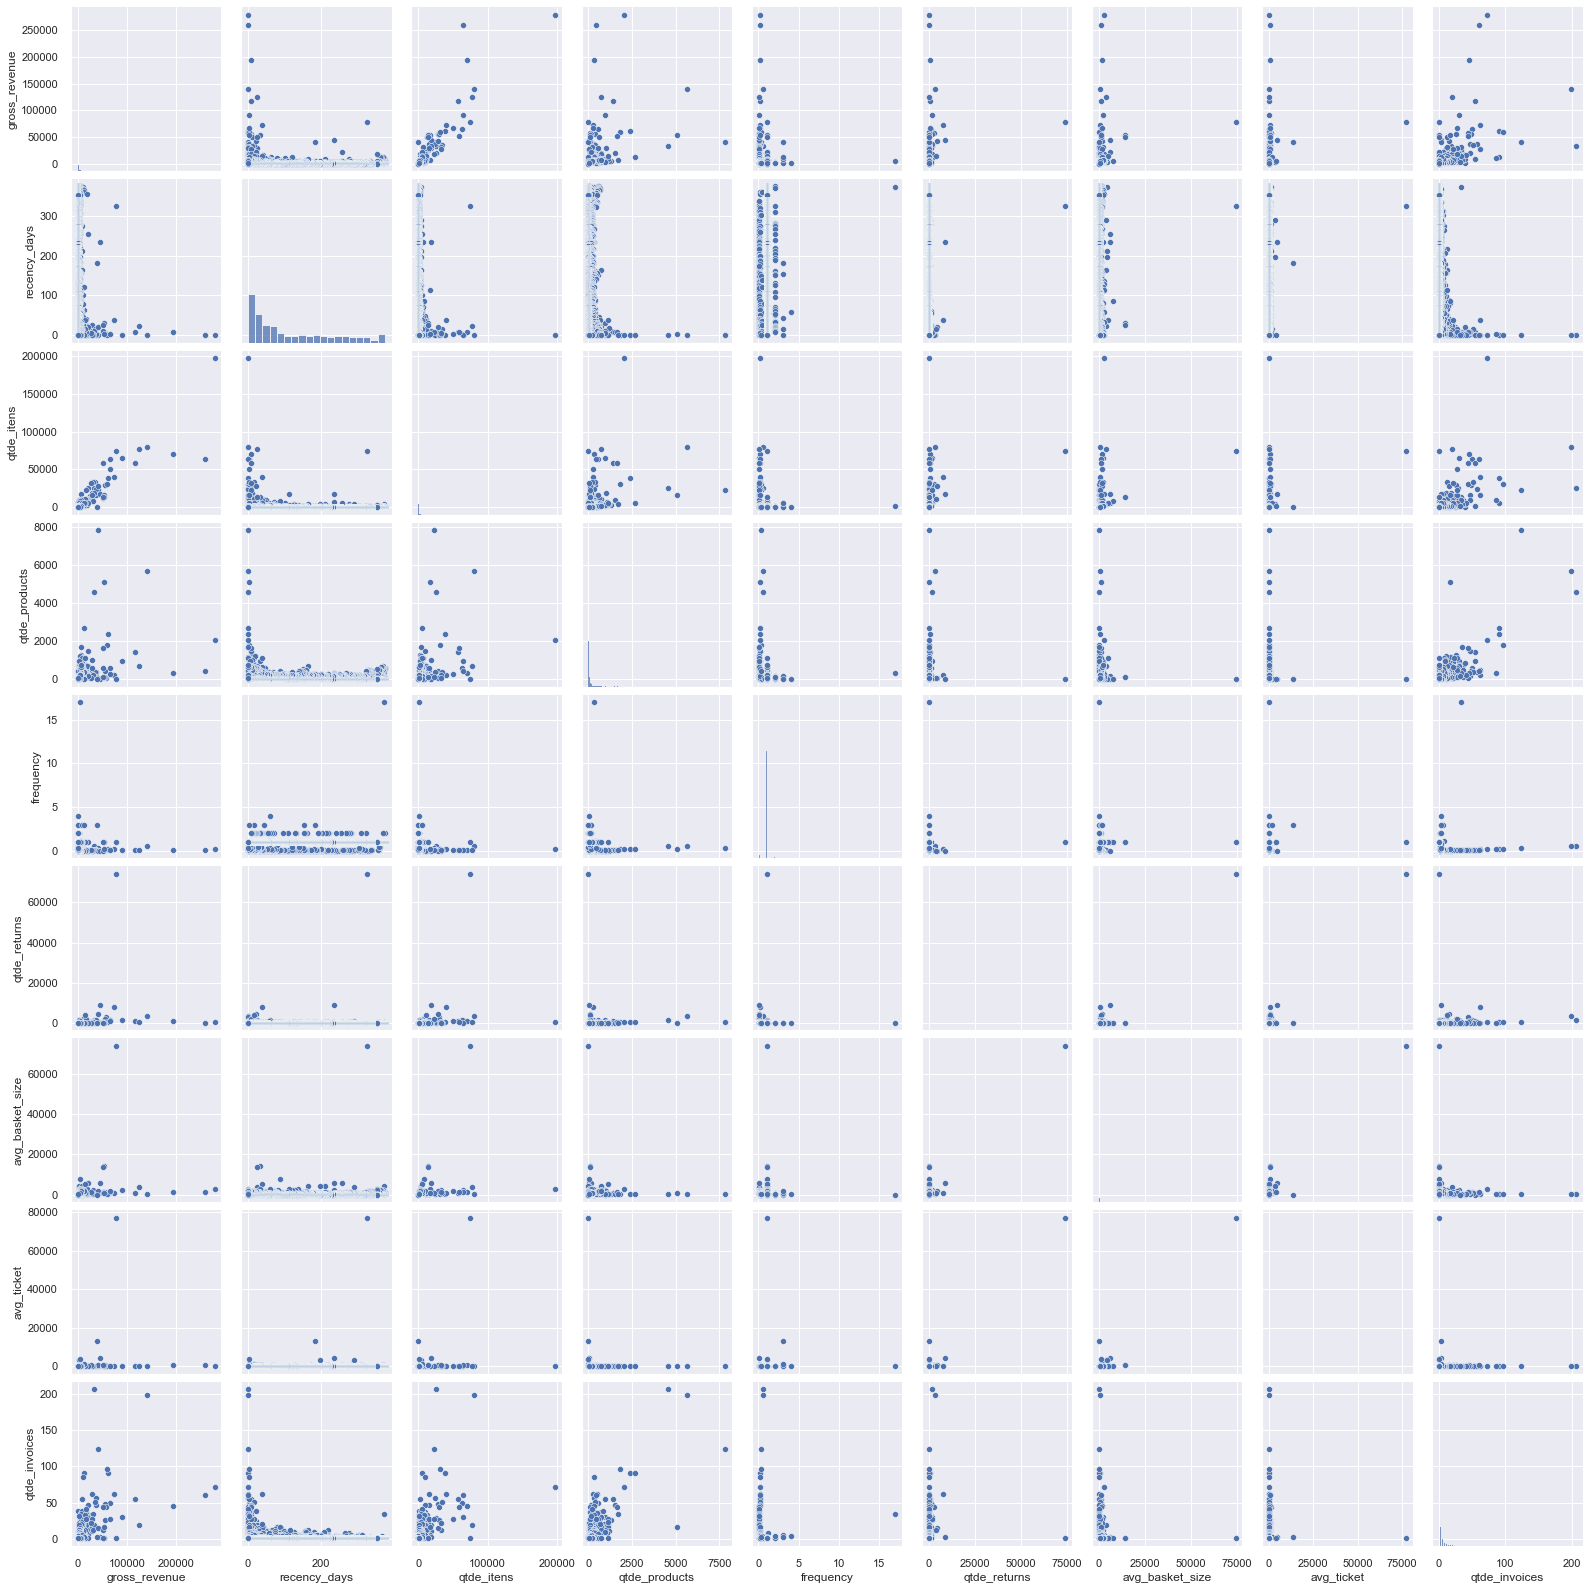

In [152]:
#plt.figure( figsize=(15, 8) )
sns.pairplot( df42 )


# <font color= 'red'> 5.0 Data Preparation
    
   
    

In [84]:
# Select Dataset
cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns', 'avg_ticket']
df43 = df4[ cols_selected ].drop( columns='customer_id', axis=1) 


In [85]:
mm = pp.MinMaxScaler()
# fs = s3fs.S3FileSystem( anon=False, key=AWS_ACCESS_KEY_ID, secret = AWS_SECRET_ACCESS_KEY)

df43[ 'avg_ticket' ]    = mm.fit_transform( df43[[ 'avg_ticket' ]] )


df43[ 'gross_revenue' ]    = mm.fit_transform( df43[[ 'gross_revenue' ]] )
# pickle.dump( mm, open('/Users/adriele/Documents/repos/pa005/src/features/gross_revenue_scaler.pkl', 'wb') )
# pickle.dump( mm, fs.open('s3://cluster-insiders-dataset/gross_revenue_scaler.pkl', 'wb') )


df43[ 'recency_days' ]     = mm.fit_transform( df43[[ 'recency_days' ]] )
# pickle.dump( mm, open('/Users/adriele/Documents/repos/pa005/src/features/recency_days_scaler.pkl', 'wb') )
# pickle.dump( mm, fs.open('s3://cluster-insiders-dataset/recency_days_scaler.pkl', 'wb') )

df43[ 'qtde_products' ]    = mm.fit_transform( df43[[ 'qtde_products' ]] )
# pickle.dump( mm, open('/Users/adriele/Documents/repos/pa005/src/features/qtde_products_scaler.pkl', 'wb') )
# pickle.dump( mm, fs.open('s3://cluster-insiders-dataset/qtde_products_scaler.pkl', 'wb') )


df43[ 'frequency' ] = mm.fit_transform( df43[[ 'frequency' ]] )
# pickle.dump( mm, open('/Users/adriele/Documents/repos/pa005/src/features/frequency_scaler.pkl', 'wb') )
# pickle.dump( mm, fs.open('s3://cluster-insiders-dataset/frequency_scaler.pkl', 'wb') )


df43[ 'qtde_returns' ]     = mm.fit_transform( df43[[ 'qtde_returns' ]] )
# pickle.dump( mm, open('/Users/adriele/Documents/repos/pa005/src/features/qtde_returns_scaler.pkl', 'wb') )
# pickle.dump( mm, fs.open('s3://cluster-insiders-dataset/qtde_returns_scaler.pkl', 'wb') )


x = df43.copy()

## 5.1 Space Study

### 5.1.1 PCA



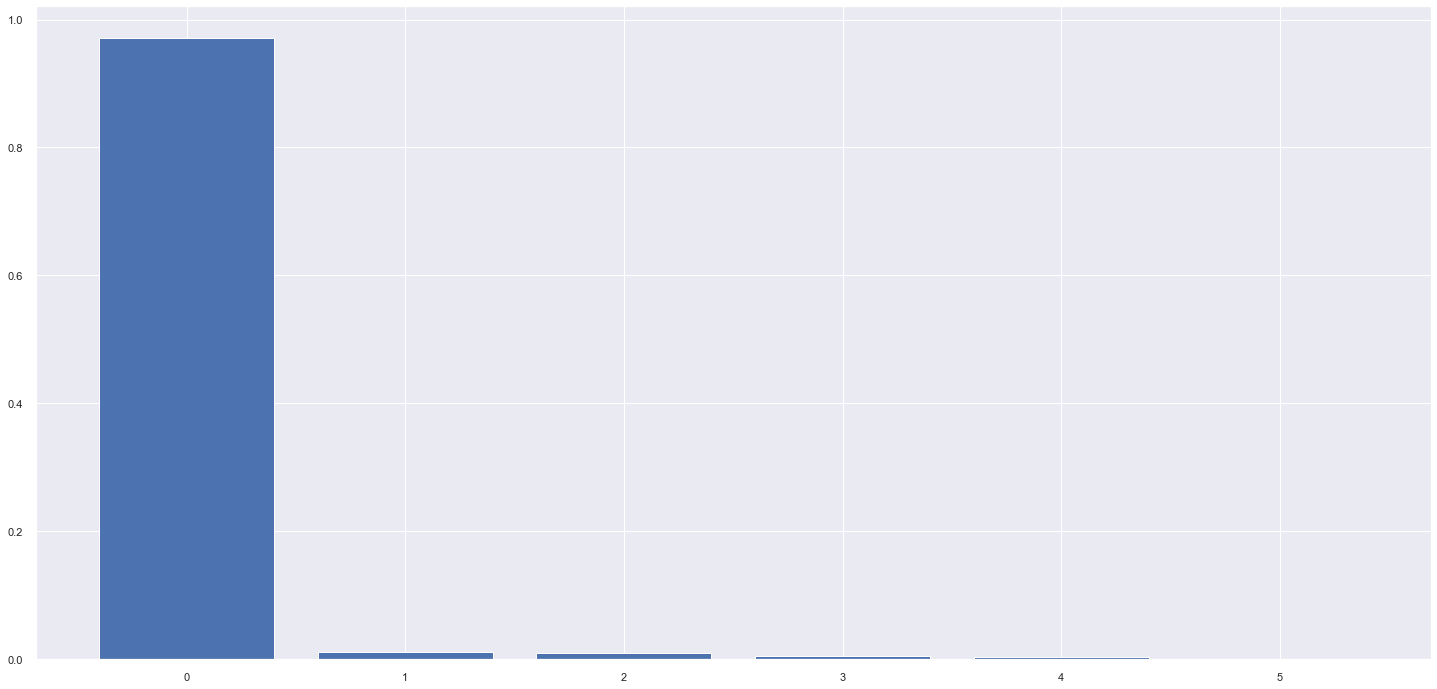

In [86]:
x_pca = df43.copy()
pca = dd.PCA( n_components =  x_pca.shape[1] )

principal_components = pca.fit_transform( x_pca )

# Plot Explaneid Variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_ )

# PCA Conponent
df_pca = pd.DataFrame( principal_components )

<AxesSubplot:xlabel='0', ylabel='1'>

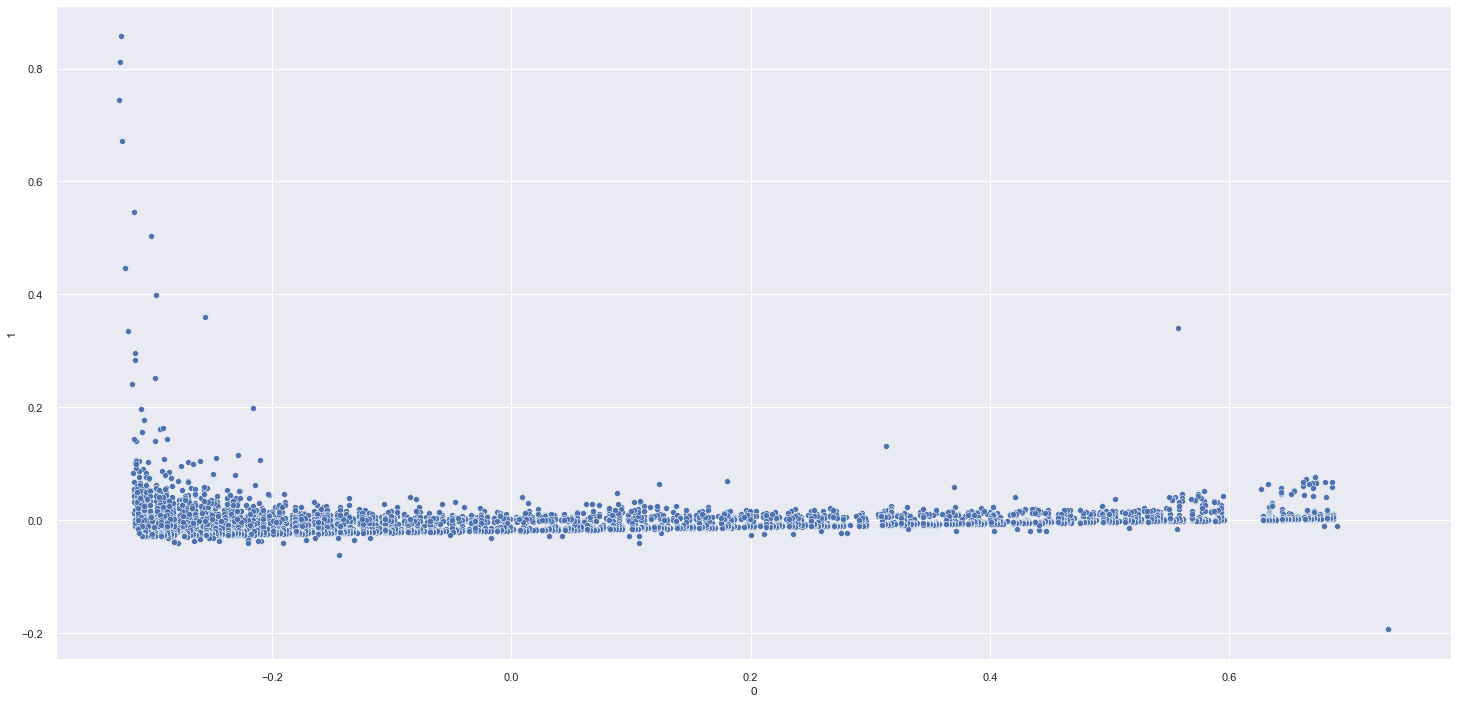

In [87]:
sns.scatterplot( x=0, y=1, data=df_pca )

### 5.1.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

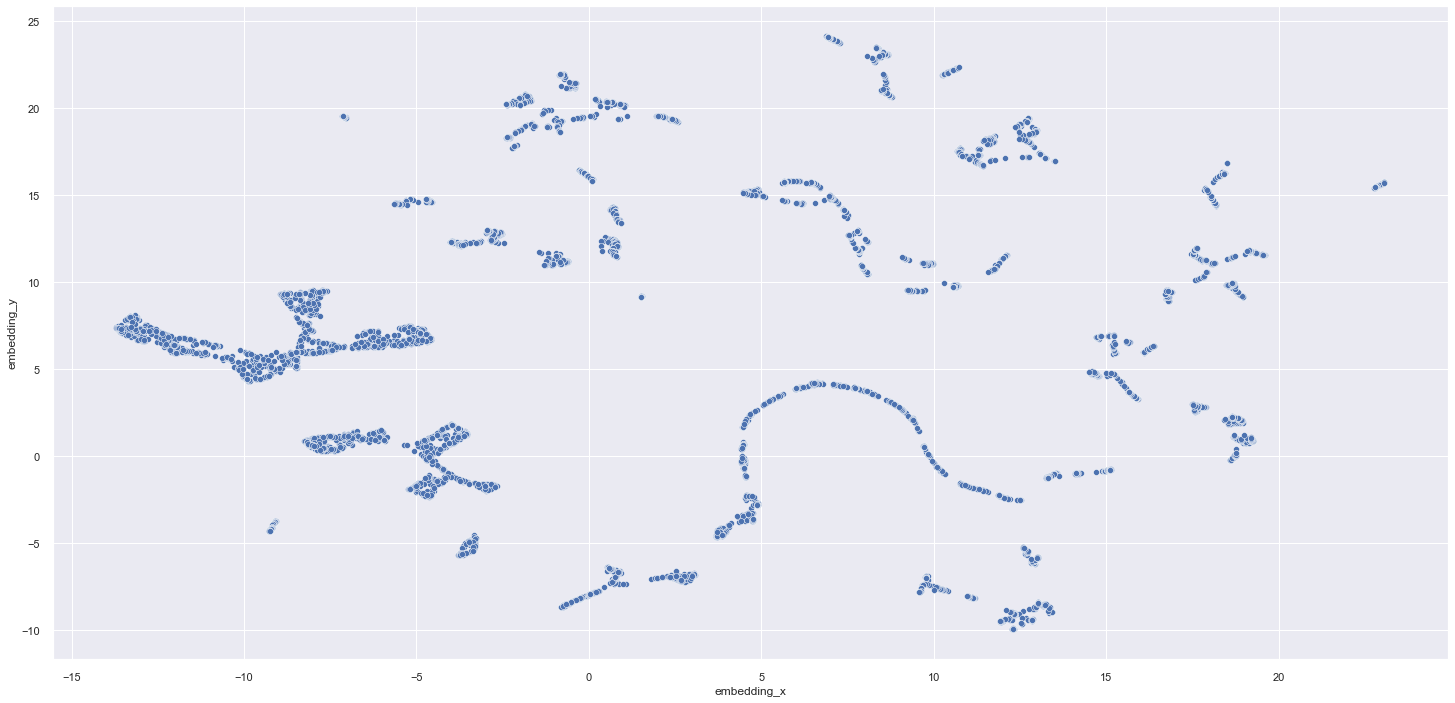

In [88]:
# reducer = umap.UMAP( random_state=42 )
# embedding = reducer.fit_transform( x )

# # Embedding
# df_pca['embedding_x'] = embedding[:, 0]
# df_pca['embedding_y'] = embedding[:, 1]


# # Plot UMAP
# sns.scatterplot( x='embedding_x',
#                  y='embedding_y',
#                  data = df_pca )

reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( x )

df_umap = pd.DataFrame()
# Embedding
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_umap )

### 5.1.3 T-SNE

/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/adriele/opt/anaconda3/envs/env_pa005/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

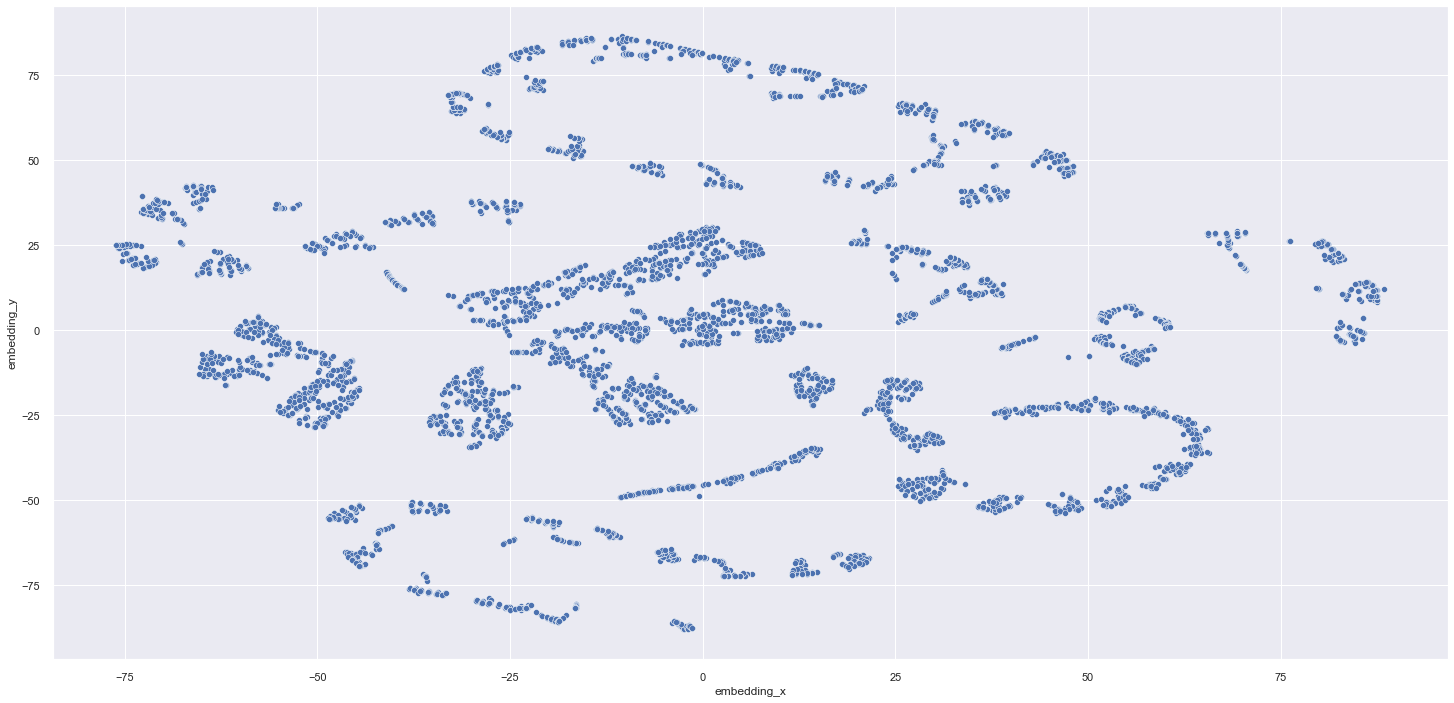

In [89]:
# reducer = mn.TSNE( n_components=2, random_state=42, n_jobs =1)

# embedding = reducer.fit_transform( x )

# # Embedding
# df_pca['embedding_x'] = embedding[:, 0]
# df_pca['embedding_y'] = embedding[:, 1]


# # Plot UMAP
# sns.scatterplot( x='embedding_x',
#                  y='embedding_y',
#                  data = df_pca )

reducer = mn.TSNE( n_components=2, random_state=42, n_jobs =1)

embedding = reducer.fit_transform( x )

df_tsne = pd.DataFrame()
# Embedding
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tsne )

### 5.1.4 Tree Based Embeding

In [90]:
 # Tree training
x = df43.drop( columns=[  'gross_revenue' ], axis=1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=150, random_state=42 )

# Model training - Treinei o modelo com x p prever o Y ( montar a estrutura da arvore)
rf_model.fit( x, y )


# pickle.dump( rf_model, open('/Users/adriele/Documents/repos/pa005/src/models/rf_model.pkl', 'wb') )
# pickle.dump( rf_model, fs.open('s3://cluster-insiders-dataset/rf_model.pkl', 'wb') )

# dataframe Leaf -  Pegar a estrutura e aplicar nos dados de treino (X) para criar as folhas
df_leaf= pd.DataFrame( rf_model.apply( x ) )

In [91]:
df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149
0,6483,7003,6780,6607,6574,6975,6887,6841,6561,6955,6549,6457,6880,6814,6541,6437,6503,6750,6911,6790,6950,6830,6863,6855,6853,6857,6860,6891,6479,6917,6940,6629,6651,6833,6848,6985,6884,7004,6407,6949,6914,6864,6852,6591,6770,6541,6838,6902,6887,6850,7015,6576,6532,6763,6973,6521,6389,6629,6652,6470,6563,6885,6882,6694,6392,6904,6811,6414,6802,6939,6825,6869,6386,6707,6664,6503,6879,6533,7017,6970,6942,6857,6948,6515,6627,6807,6513,6618,6804,6921,6998,6926,6599,6800,6844,6746,6521,6484,6524,6593,6933,6781,6930,6795,6971,6926,6937,6379,6603,6482,6931,6854,6712,6971,6518,6425,6906,6590,6947,6767,6938,6878,6774,6831,6877,6840,6911,6964,6707,6727,7034,6862,6938,6794,6696,6924,6786,6847,7072,6511,6959,6846,6416,6463,6952,6902,6886,6752,6956,6909
1,6308,6382,6600,6312,6343,6797,6297,5964,6393,6422,6129,6186,6180,6579,6257,6269,6191,5969,6286,5786,6797,6110,6723,6256,6016,5851,6675,6058,6346,6616,6778,6523,6083,6231,6635,6735,5910,6644,6283,5981,6313,6250,5903,6230,6550,6306,5969,6307,6553,6280,6362,6267,6448,6554,6039,6386,6245,6369,6334,6265,6138,6145,6676,6451,6224,6356,6655,6302,6481,6637,5769,6221,6291,6183,6460,6239,5879,6392,6254,6261,6617,5968,6241,6436,6152,6569,6433,6394,5897,6809,6359,6571,6421,6747,6512,6406,6168,6346,6414,6374,6665,6468,6350,5859,6125,6248,6351,6206,6271,6329,6427,6261,6375,6224,6403,6227,5764,6438,6178,5959,5984,5894,6203,6724,6123,5645,6248,6226,6382,6531,6408,5850,5903,6580,5800,6010,5767,6181,6369,6336,6370,5873,6052,6206,6265,6028,5871,5920,6294,6214
2,6506,6468,6739,6571,6517,6910,6391,6849,6582,6929,6452,6410,6298,6721,6520,6441,6520,6667,6428,6753,6973,6255,6819,6879,6839,6839,6848,6840,6486,6786,6924,6660,6593,6826,6855,6860,6814,6838,6457,6931,6477,6752,6881,6622,6632,6510,6923,6475,6773,6408,6429,6503,6565,6784,6914,6496,6398,6557,6706,6455,6568,6833,6888,6652,6565,6454,6747,6488,6650,6793,6785,6360,6436,6798,6906,6528,6934,6564,6378,6413,6840,6934,6932,6539,6582,6728,6468,6649,6771,6782,6476,6738,6524,6806,6729,6619,6539,6535,6592,6810,6799,6695,6495,6285,7016,6322,6491,6414,6553,6474,6935,6771,6664,6370,6541,6429,6938,6576,6369,6789,6783,6860,6433,6904,6293,6843,6404,6376,6653,6745,6539,6787,6961,6711,6723,6985,6800,6384,6496,6512,6481,6811,6393,6451,6416,6835,6332,6788,6400,6338
3,2566,4214,1210,2816,2351,3458,2538,3054,3983,3148,3640,3901,2608,917,3005,3594,3385,497,3821,3368,2590,3737,2787,4615,555,3161,2841,3470,2575,3154,3344,3272,3434,3006,2994,2993,3066,4179,3279,914,2562,2584,4154,3420,2518,2843,3368,2525,2742,2784,4289,3480,3329,2635,3921,3451,3353,2850,4197,3826,3202,4478,686,2761,2561,3404,3203,3128,785,2873,547,3048,3863,980,3681,3943,4245,3523,3658,2660,2700,3243,829,3612,2380,2817,2522,4610,3135,2644,4207,2886,2884,2841,4544,868,2443,3301,3534,3261,3160,2772,2796,2540,644,4144,3749,4275,3404,3325,3156,2813,2766,3340,2553,2630,3294,4327,942,3188,428,576,2847,1254,3303,3879,2715,3614,2846,3332,3866,3164,4114,2899,2523,3332,3430,2431,4366,4201,3300,3709,3436,2855,4190,671,3221,571,1316,4278
4,4327,4074,4186,4511,2467,3859,4130,3908,3548,4752,4300,2317,4202,1171,3441,4408,4120,4294,4544,4223,4401,4422,4610,4400,4444,3845,4507,4230,4440,3815,4915,3930,4248,3266,3467,3259,3785,3905,4183,4131,4578,2737,4451,4089,4672,4596,4127,4238,4431,4611,4009,3867,4034,4483,4593,3895,4219,3293,3973,4292,3704,4333,4470,4754,4347,4157,3909,4258,3576,4917,1279,3963,4309,6934,5362,4363,4042,4050,4342,4292,4697,3966,1246,4322,4534,4691,4120,4505,3887,4713,4563,4681,4794,4660,4467,1090,4549,3869,4261,4121,3802,4544,4639,

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

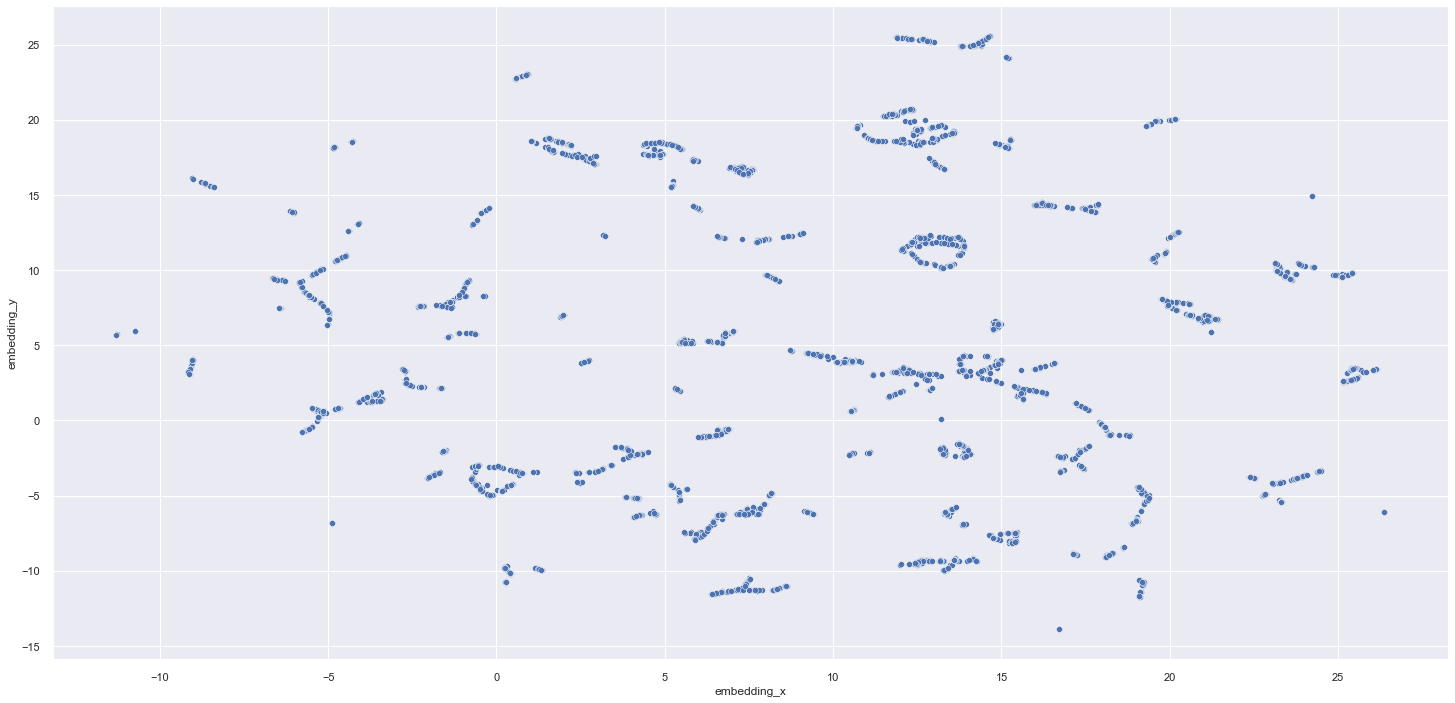

In [92]:
# leaf tree
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# pickle.dump( reducer, open('/Users/adriele/Documents/repos/pa005/src/models/umap_reducer.pkl', 'wb') )
# pickle.dump( reducer, fs.open('s3://cluster-insiders-dataset/umap_reducer.pkl', 'wb') )


# Embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]


# Plot UMAP
sns.scatterplot( x='embedding_x',
                 y='embedding_y',
                 data = df_tree )

# <font color= 'red'>  6.0 Feature Selection

In [93]:
# umap Embedding
df5 = df_umap.copy()
#x = df_tree.copy()
#x= df_tsne.copy()
x = df_umap.copy()

# <font color= 'red'> 7.0 Fine Tunning Hyperparameter

In [94]:
#x = df6.drop( columns=['customer_id'] )
#clusters = [2, 3, 4, 5, 6, 7, 8, 9]


clusters = np.arange(2, 26, 1)

In [95]:
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25])

## 7.1 K-Means

* Calculates the distance from the centroids. Of centroids move to create the clusters.

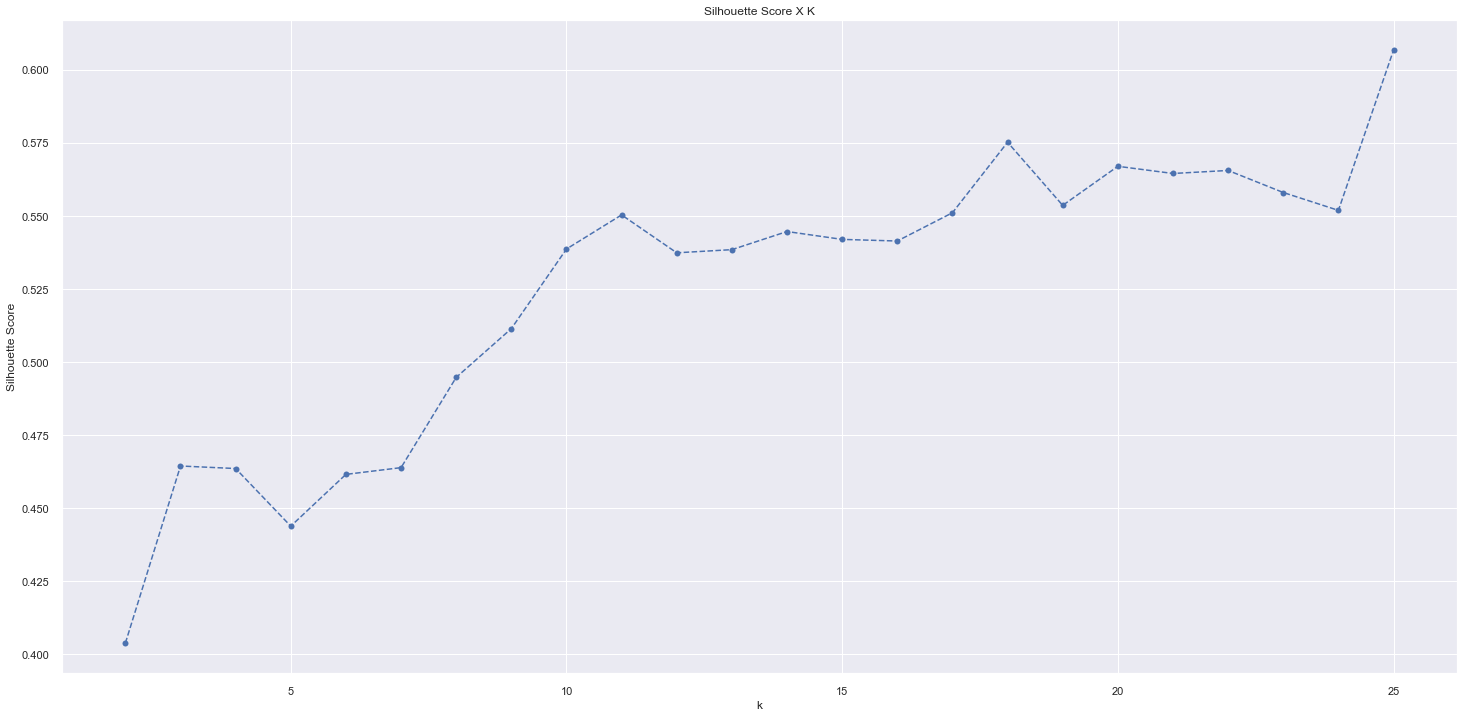

In [96]:
from  sklearn  import  cluster       as c

kmeans_list = []
for k in clusters:
    # Model definition
    kmeans_model = c.KMeans( n_clusters=k )

    # Model training
    kmeans_model.fit( x )

    # Model  predict
    labels = kmeans_model.predict( x )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    kmeans_list.append( sil )
    
    
    
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score X K');

## 7.2 GMM
* Assume that the points came from a Gaussian distribution.
* The algorithm calculates the mean, and the standard deviation around the mean.
* Calculates the distance of points from the Gaussian.
* It moves until it creates clusters.

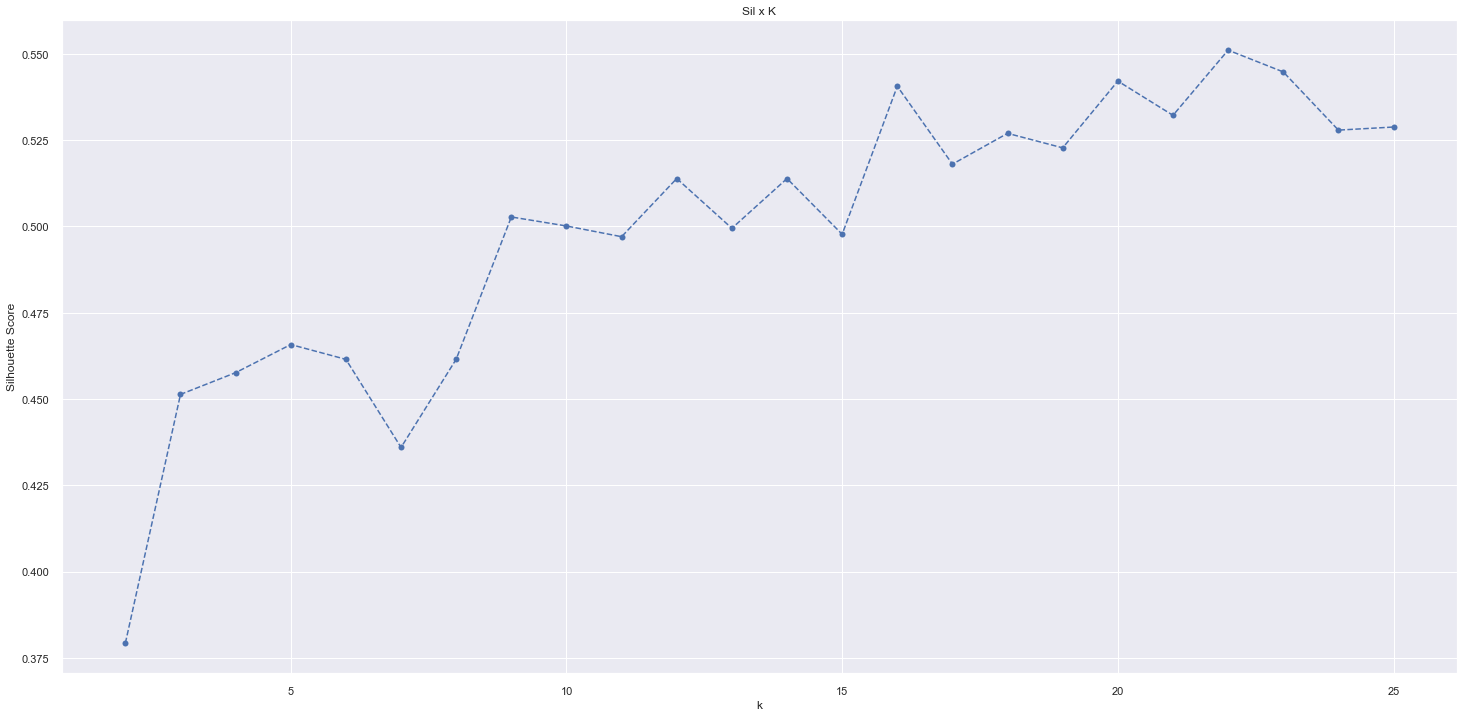

In [97]:
gmm_list = []
for k in clusters:
    # Model definition
    gmm_model = mx.GaussianMixture( n_components=k )

    # Model training
    gmm_model.fit( x )

    # Model  predict
    labels = gmm_model.predict( x )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    gmm_list.append( sil )
    
    
    
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.3 Hierarchical Clustering
* Assumes that each point is a cluster.
* Choose a type of distance for calculation.
* Calculates and creates clusters.

In [98]:
hc_model = hc.linkage( x, 'ward')

### 7.3.1. HClustering Silhouette Score

* Ward's method

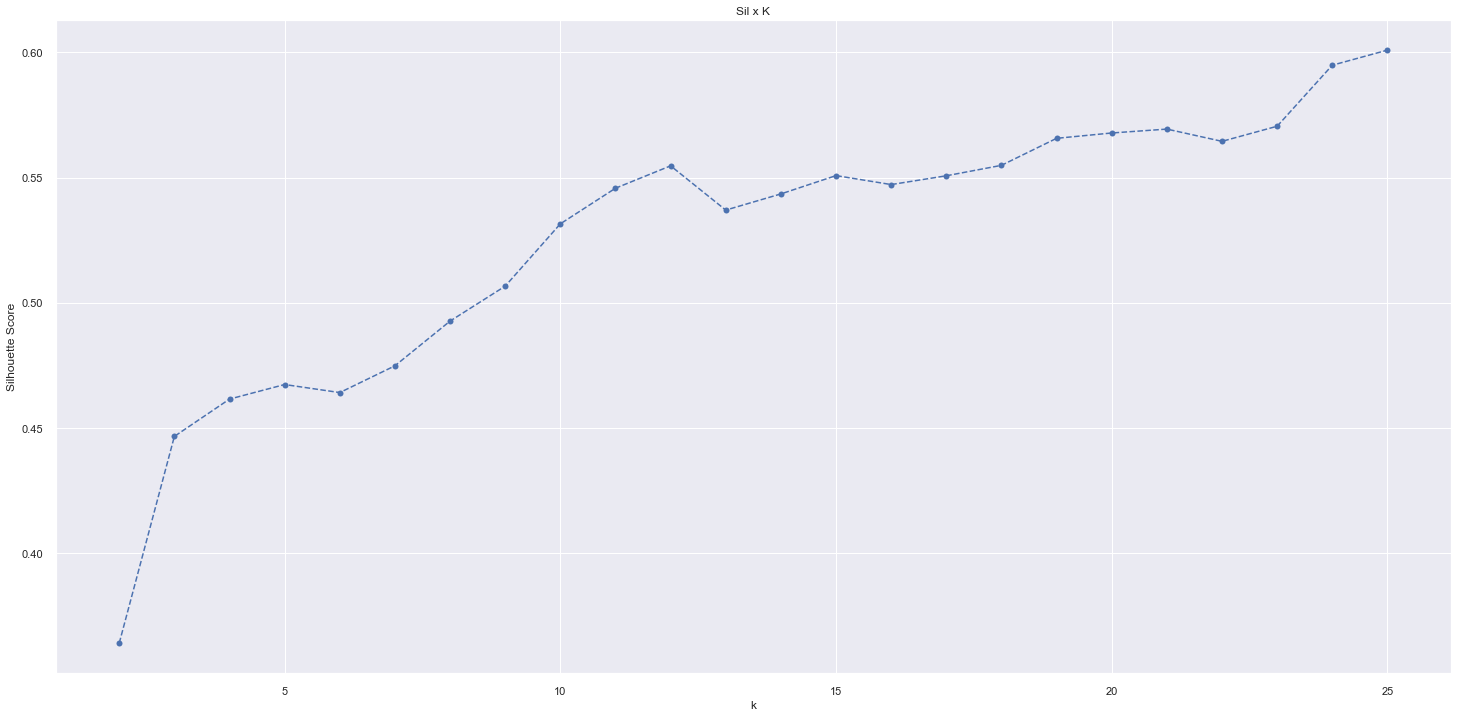

In [99]:
hc_list = []
for k in clusters:
    # Model definition
    hc_model =hc.linkage( x, 'ward' )

    # Model  predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # Model performance
    sil = m.silhouette_score( x, labels, metric='euclidean')
    hc_list.append( sil )
    
    
    
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

## 7.4 DBSCAN
* Define a radius and number of clusters;
* give labels to clusters;
* Evaluates the given labels, and creates clusters.

In [100]:
#eps =0.1
eps =2.0
min_samples = 20


# Model definition
dbscan_model =c.DBSCAN( eps=eps, min_samples=min_samples )

# Model training
labels = dbscan_model.fit_predict( x )


# Model performance
sil = m.silhouette_score( x, labels, metric='euclidean')
#dbscan_list.append( sil )


    
# plt.plot( clusters, dbscan_list, linestyle='--', marker='o', color='b')  
# plt.xlabel( 'k');
# plt.ylabel( 'Silhouette Score' );
# plt.title( 'Sil x K');

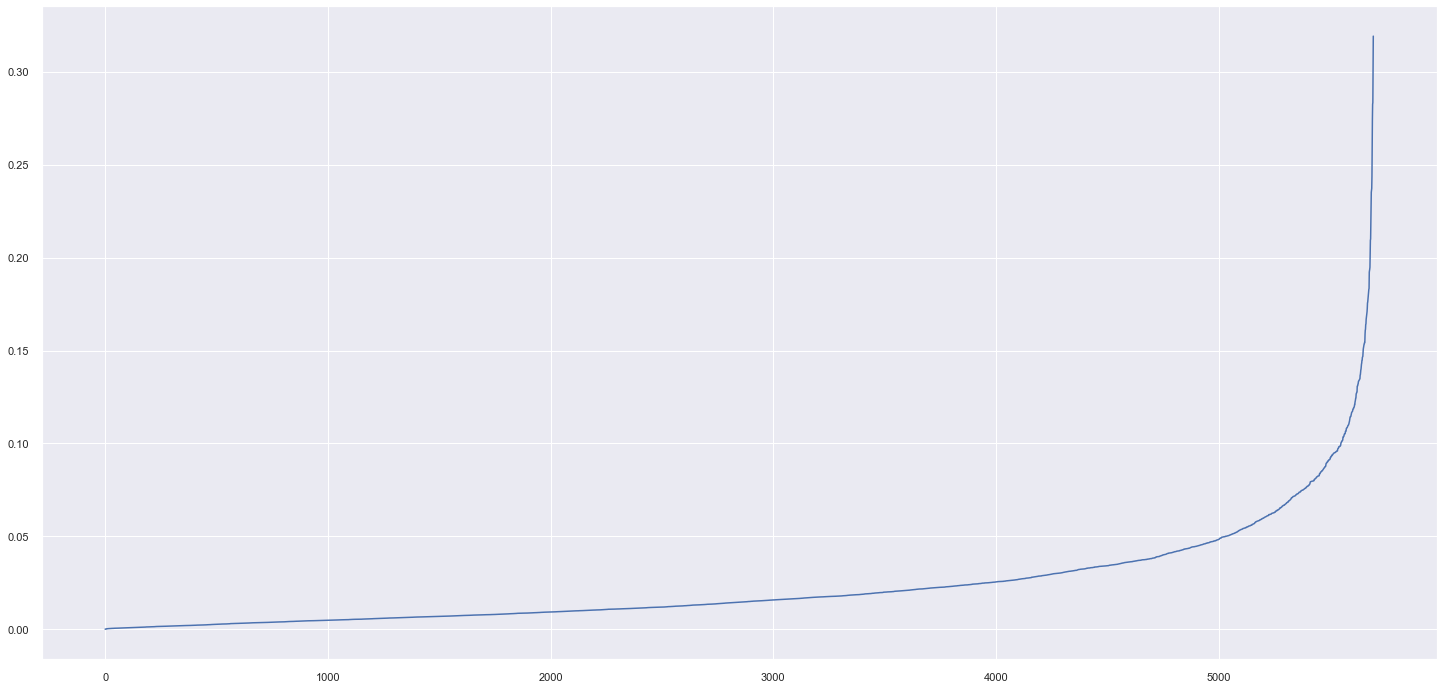

In [101]:
neigbors = NearestNeighbors( n_neighbors=min_samples ).fit( x )
distances, indices = neigbors.kneighbors( x )

distances = np.sort( distances, axis=0 )
distances = distances[:, 1]
plt.plot( distances )

## 7.5 Results

In [102]:
df_results = pd.DataFrame({'KMeans': kmeans_list,
                           'GMM' :gmm_list,
                           'HC' : hc_list }
                         
                         ).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)


,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.403695,0.464342,0.463475,0.443750,0.461473,0.463780,0.494672,0.511365,0.538626,0.550303,0.537329,0.538410,0.544612,0.541922,0.541363,0.551037,0.575182,0.553567,0.566940,0.564484,0.565518,0.557972,0.551856,0.606713
GMM,0.379327,0.451369,0.457664,0.465809,0.461516,0.436011,0.461554,0.502756,0.500143,0.497039,0.513885,0.499477,0.513880,0.497740,0.540607,0.518046,0.526976,0.522768,0.542113,0.532190,0.551073,0.544760,0.527909,0.528801
HC,0.364087,0.446641,0.461539,0.467352,0.464143,0.474829,0.492684,0.506640,0.531514,0.545742,0.554679,0.537003,0.543462,0.550777,0.547198,0.550709,0.554873,0.565664,0.567794,0.569348,0.564459,0.570489,0.594857,0.600878


## 7.6  Metric Analysis

### 7.6.1 Within Cluster Sum of Square ( WSS )

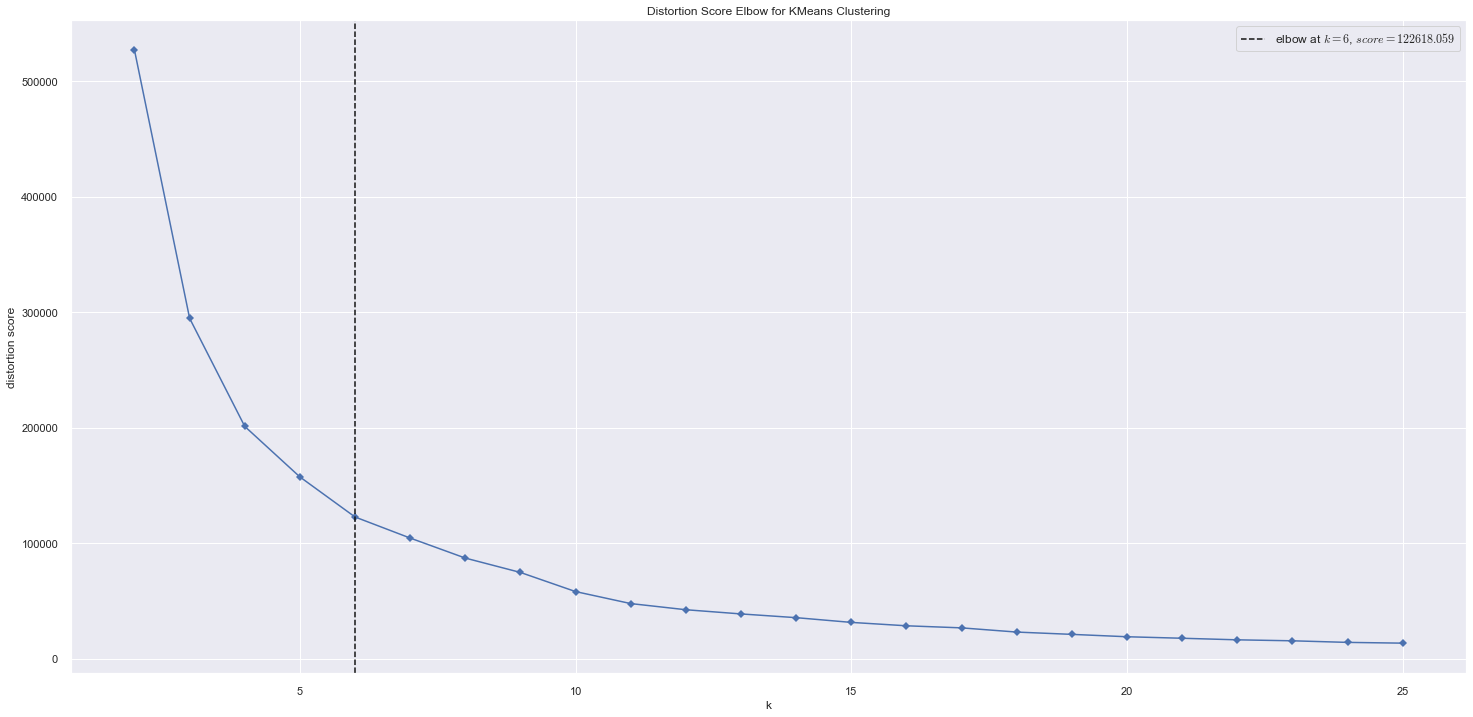

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [103]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, timings=False )
kmeans.fit( x )
kmeans.show()

* The WSS is telling that K should be equal to 7.

### 7.6.2 Silhouette Score

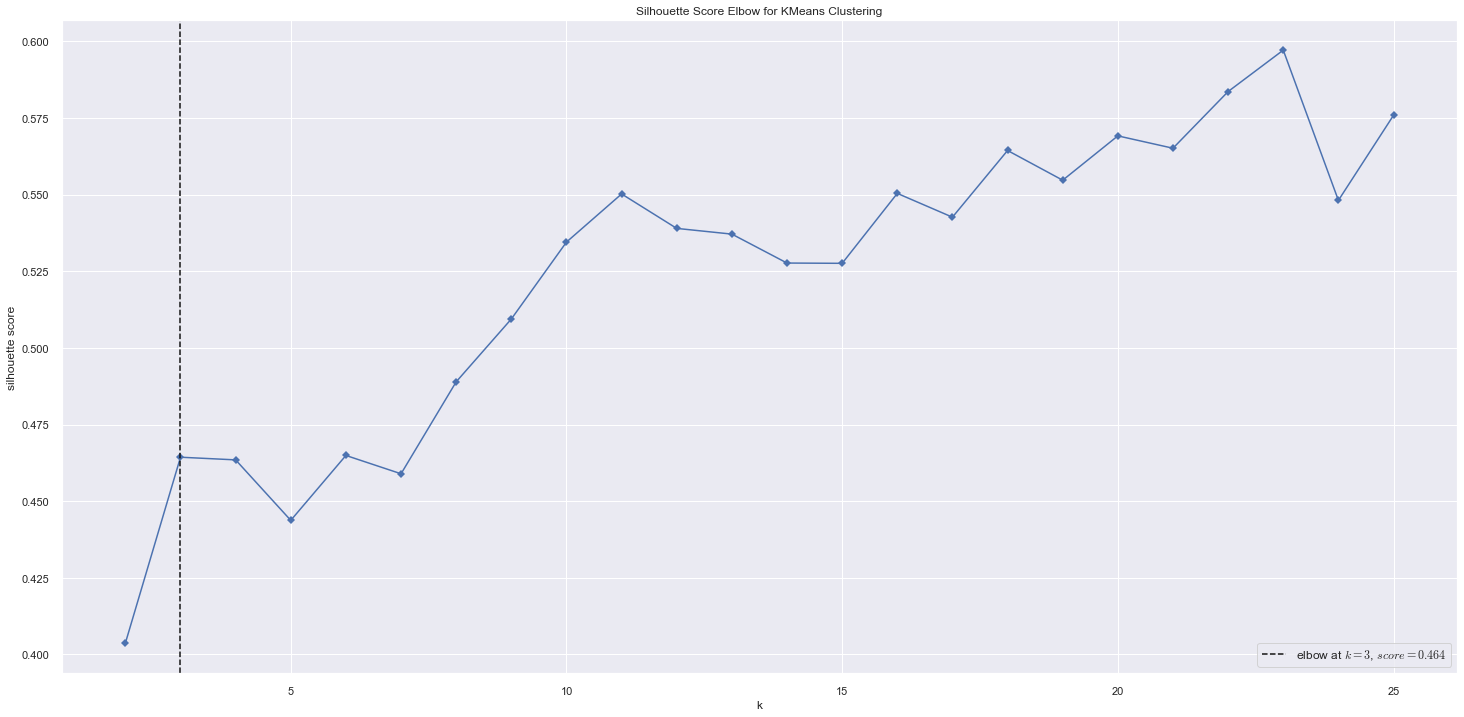

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [104]:
kmeans = KElbowVisualizer( c.KMeans(), k=clusters, metric='silhouette', timings=False )
kmeans.fit( x )
kmeans.show()

*The SS is telling that the best k is 2.

### 7.6.3 Silhouette Visualizer

For k = 2. Silhouette Score: 0.3640868365764618
For k = 3. Silhouette Score: 0.44664114713668823
For k = 4. Silhouette Score: 0.4615388810634613
For k = 5. Silhouette Score: 0.4673517644405365
For k = 6. Silhouette Score: 0.4641428291797638
For k = 7. Silhouette Score: 0.4748285114765167


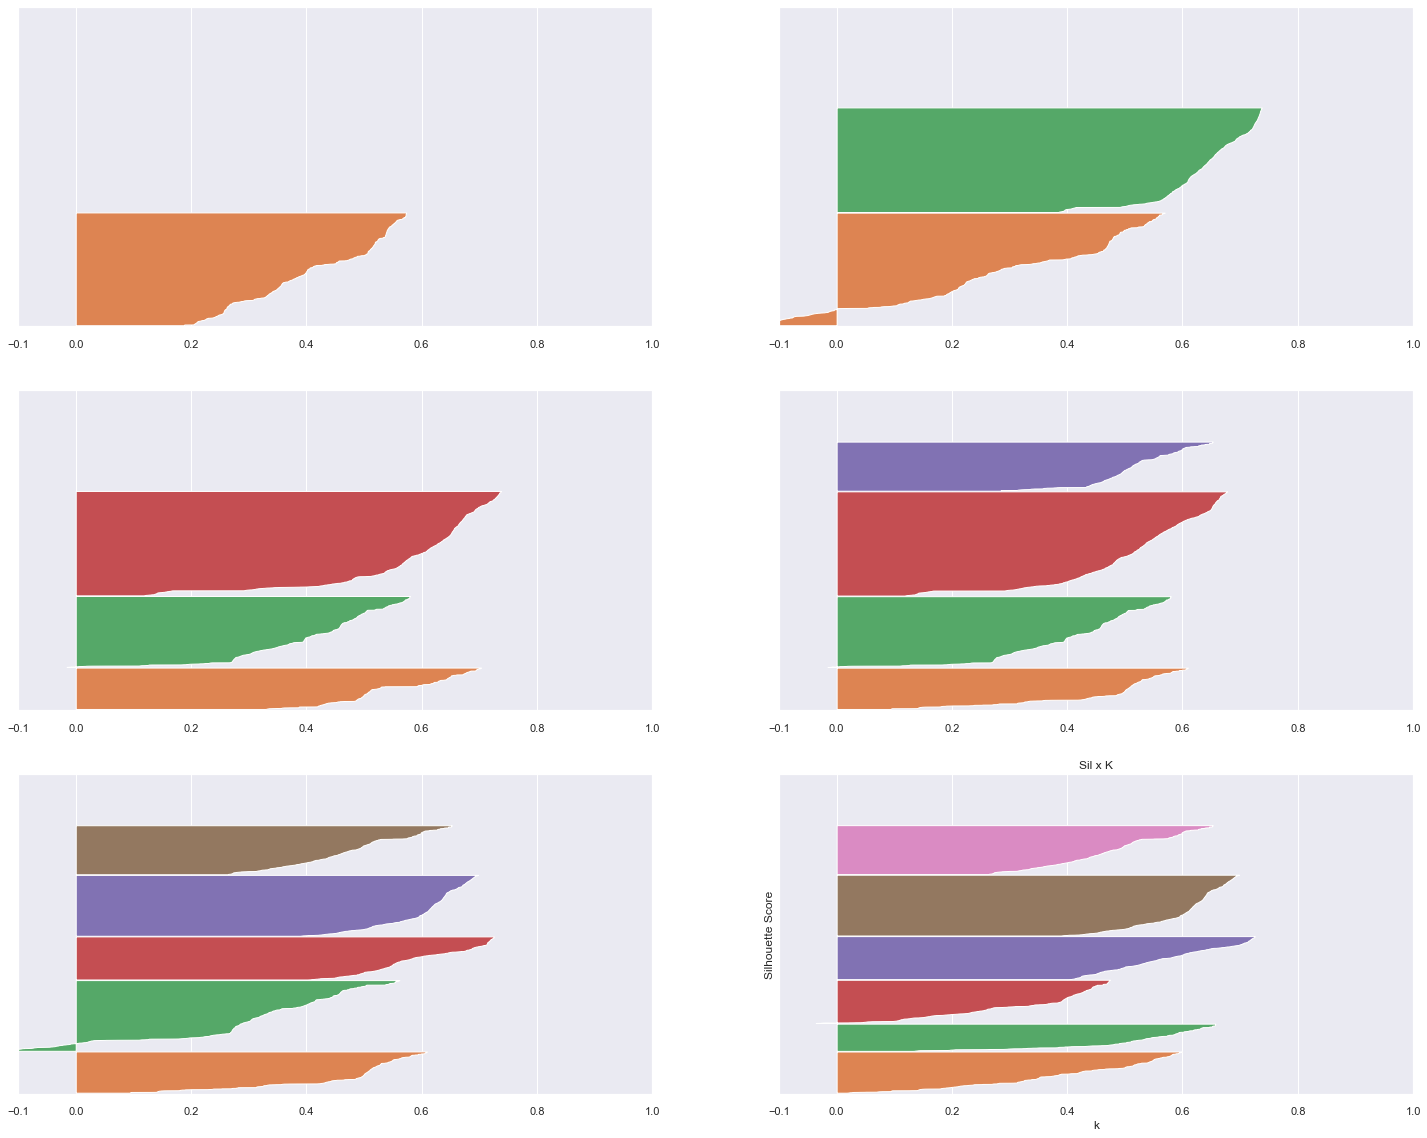

In [105]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )


for k in clusters[0:6]: 
    q, mod = divmod(k, 2 )
    
    ax[ q-1, mod].set_xlim([ -0.1, 1 ])
    ax[ q-1, mod].set_ylim([ 0, len( x ) + ( k+1 ) *10 ] )
    
    # Model definition and training
    hc_model =hc.linkage( x, 'ward' )

    # Model  predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # Model performance
    ss = m.silhouette_score( x, labels, metric='euclidean')
    print( 'For k = {}. Silhouette Score: {}'.format( k, ss ) )
    
    
    sample_silhouette_values = m.silhouette_samples( x, labels)
    
    y_lower = 10

    for i in range( k):

        # Select clusters
        ith_sample_silhouette_values = sample_silhouette_values[ labels == i]
        
        # Sort values
        ith_sample_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_sample_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap  = cm.get_cmap( 'Spectral')
        color = cmap( i /k )

    


        ax[ q-1, mod].fill_betweenx( np.arange( y_lower, y_upper), 0, ith_sample_silhouette_values )
        
        y_lower = y_upper + 10

    ax[ q-1, mod ].set_yticks([])
    ax[ q-1, mod ].set_xticks([ -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
plt.plot( clusters, hc_list, linestyle='--', marker='o', color='b')  
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K');

* The clusters shows glueds. 
* Most of graps shows that the customers are, possible, in a wrong cluster.

# <font color= 'red'> 8.0 Model Training

In [106]:
df8 = df43.copy()

## 8.1 Final Model

In [107]:
#Model definition

k = 4
kmeans =c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )

# Model training
kmeans.fit( x )

# Clustering
labels = kmeans.labels_

In [108]:
# ##############################
# k=6
# # Model definition
# gmm_model = mx.GaussianMixture( n_components=k, n_init=300, random_state=32 )

# # Model training
# gmm_model.fit( x )

# # Model  predict
# labels = gmm_model.predict( x )



## 8.2 Cluster Validation

In [109]:
# WSS (Within cluster sum of square)
#print( 'WSS value: {}'.format( kmeans.inertia_ ) )

# SS ( Silhouette score )
print( 'SS value: {}'.format( m.silhouette_score( x, labels, metric='euclidean' ) ) )

SS value: 0.463474303483963


* WSS - Calculates only the distance of the points.
* SS - Calculates the distances and cohesion of Clusters
* SS - The closer to 1 means the cluters. They are condensed and distant.

# <font color= 'red'> 9.0 Cluster Analysis

In [110]:
df92 = x.copy()
df92['cluster'] = labels

## 9.1 Visualization Inpection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

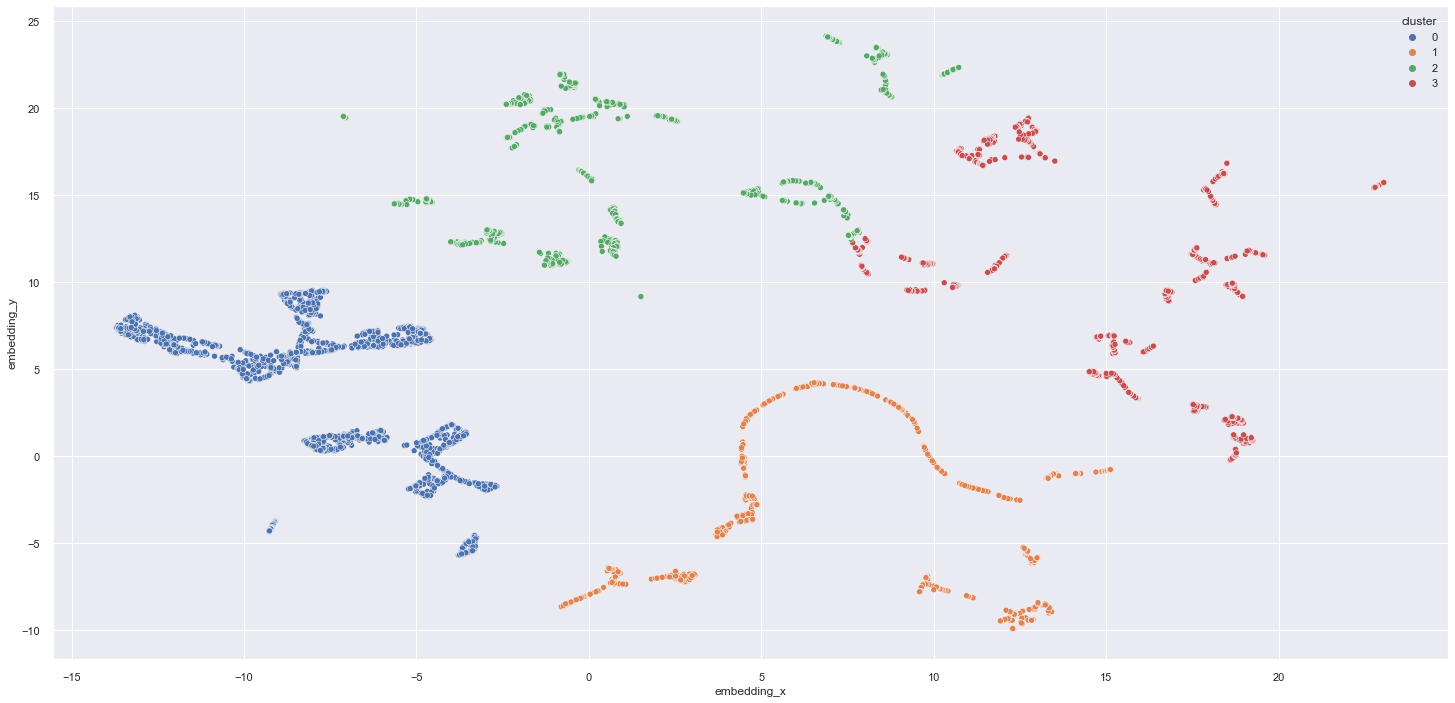

In [111]:
# visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
# visualizer.fit ( x )
# visualizer.finalize()

sns.scatterplot( x= 'embedding_x', y='embedding_y', hue='cluster', data=df92, palette='deep')

## 9.4 Cluster Profile

In [112]:
df92= df4[cols_selected].copy()
df92['cluster'] = labels
df92.head()

,customer_id,gross_revenue,recency_days,qtde_products,frequency,qtde_returns,avg_ticket,cluster
0,17850,5391.21,372.0,297.0,17.000000,40.0,27.223103,1
1,13047,3232.59,56.0,171.0,0.028302,35.0,22.883617,1
2,12583,6705.38,2.0,232.0,0.040323,50.0,35.595256,0
3,13748,948.25,95.0,28.0,0.017921,0.0,32.147500,1
4,15100,876.00,333.0,3.0,0.073171,22.0,262.800000,1


In [113]:
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross Revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Agv recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice no
df_qtde_products= df92[['qtde_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Returns
df_qtde_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qtde_returns, how='inner', on='cluster' )

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,1877,32.958736,3742.404017,18.850293,172.156100,0.059919,41.135855
1,1,1276,22.405619,1211.506975,193.335423,67.780564,0.317785,74.065047
2,2,1314,23.072871,618.281826,72.194825,44.295282,1.024272,3.391933
3,3,1228,21.562774,587.834520,235.310261,48.519544,1.020358,1.544788


# Assumptions:
What is a good customer?
- The customer who buys a large quantity of products;
- The customer who has a low recency.
- The customer who has a high frequency.

The cluster that most identified with these criteria was cluster number 0.

# <font color= 'red'> 10.0 Deploy to production

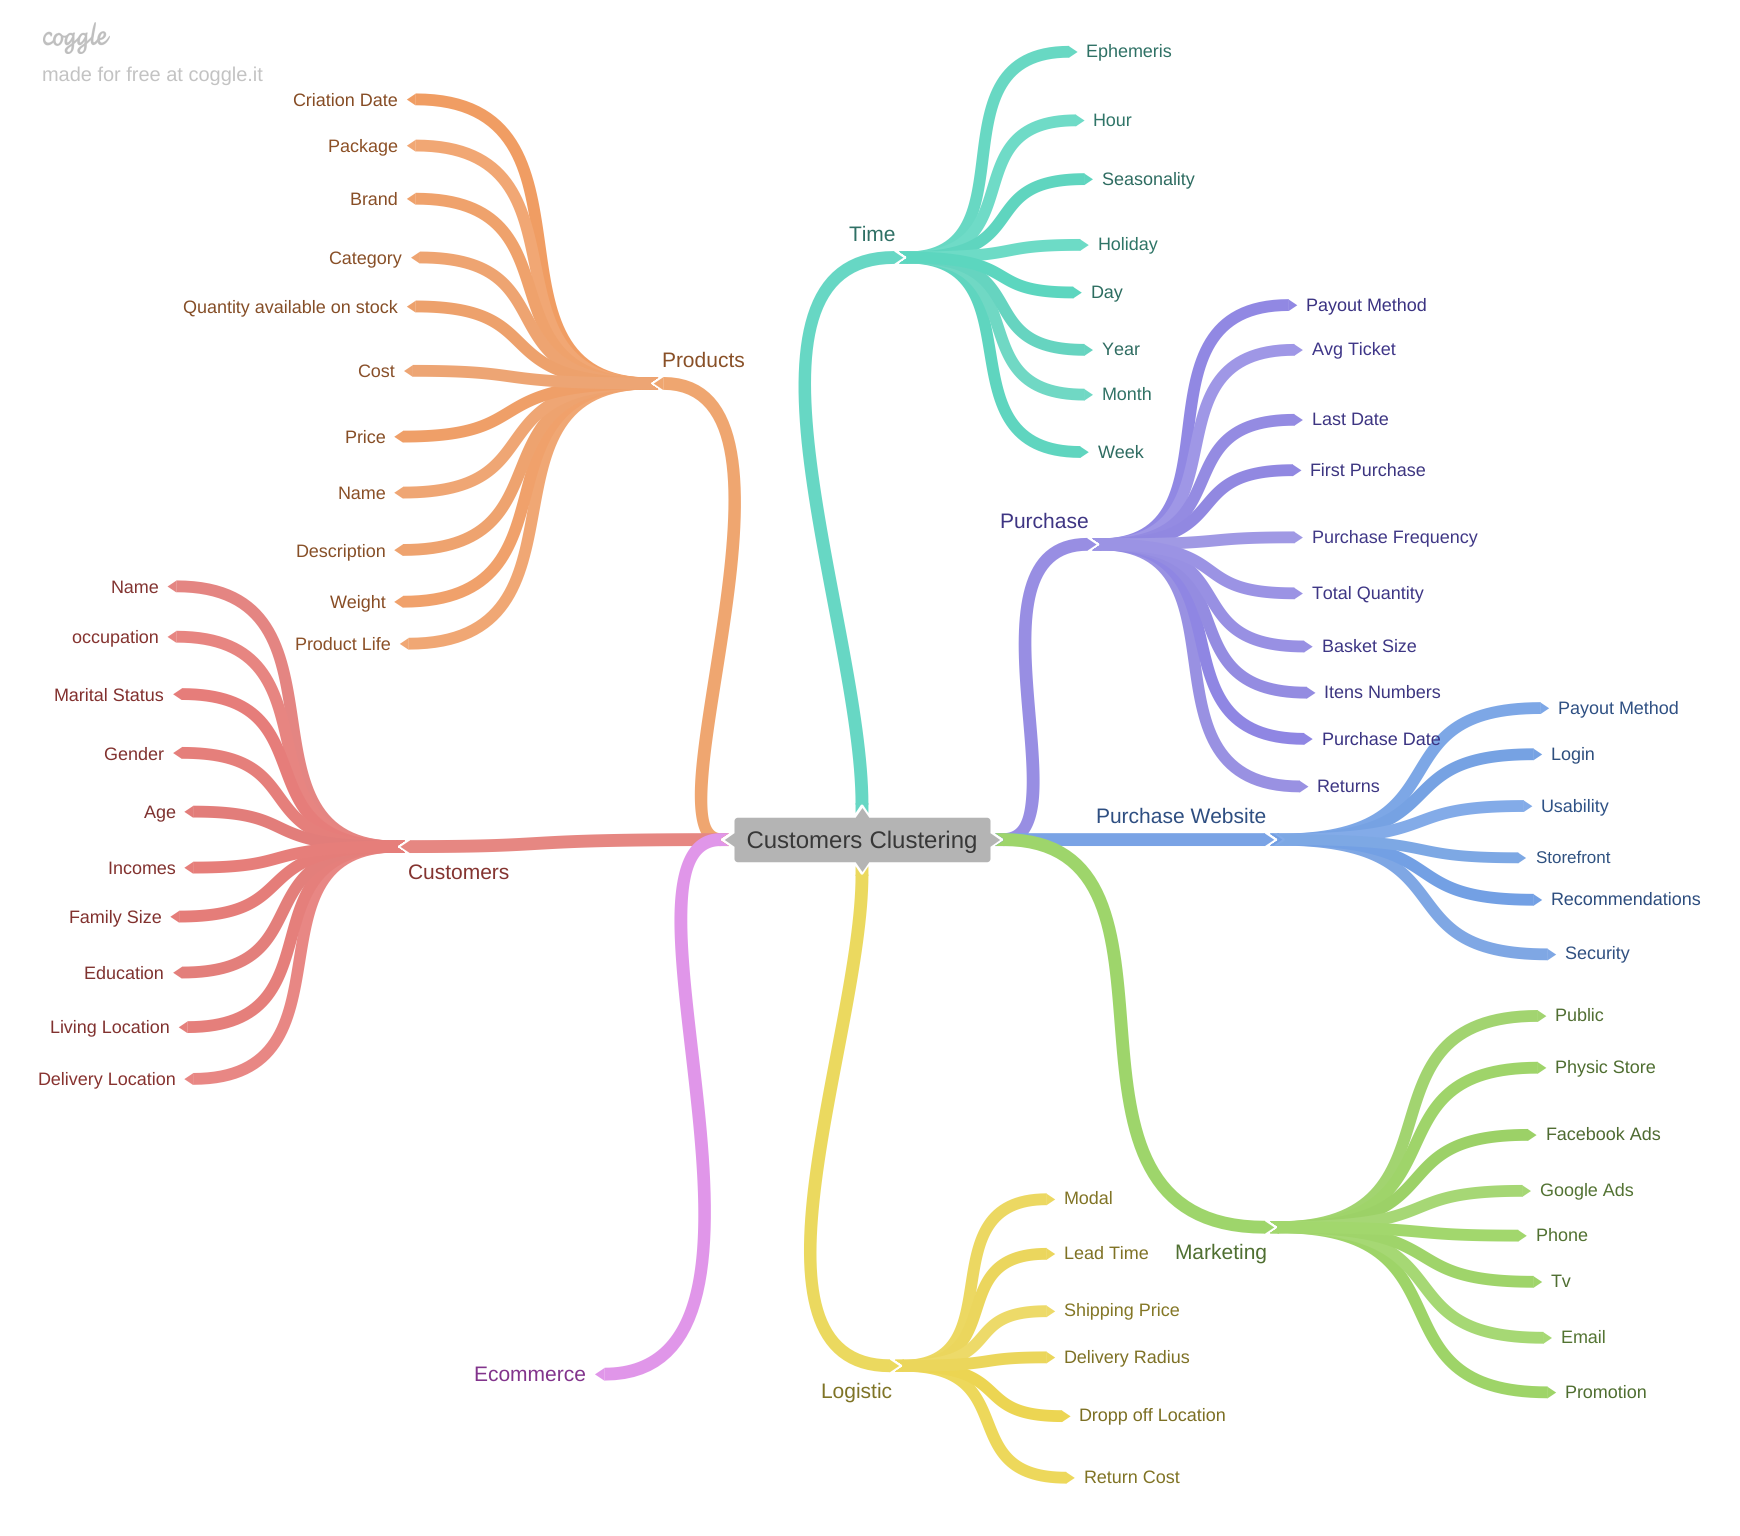

In [114]:
df10 = df92.copy()

Image ('/Users/adriele/Documents/repos/pa005/image/mindmap.png')

## Purchase Hypothesis

1. The customers of the cluster insiders are using credit card in 80% of purchase;
2. The customers of the cluster insiders has a average ticket of 10% over to cluster More Products;
3. The customers of the cluster insiders has a bascket size over of 5 products;
4. The customers of the cluster insiders has a amount of purchase over 10% of purchase total;
5. The customers of the cluster insiders has a amount of returns bellow averange of total base of customers;
7. The revenue median by customers of the cluster insiders are 10% larger than the total revenue median;
8. The gmv percentage purchased by customers of the cluster insiders;

## Customers Hypothesis

1. 60% of customers of the cluster insiders are single;
2. 10% of  customers of the cluster insiders are between 24 to 35 years old;
3. 40% of delivery location of the cluster insiders are between 50km;
4.  5% of customers of the cluster insiders has incomes more than 100k annually;



## Product Hypothesis

1. 30% of total products in large packeges are purchased by customers of the cluster insiders;
2. The averange weight of purchased products by customers of the cluster insiders are highest than others clusters average weight;
3. The averange product life purchased by customers of the cluster insiders are bellow than 15 days;



## 10.2 Hypothesis validation

### H1. The customers of the cluster insiders, has a amount (product) of purchase over 10% of purchase total;
**True:** The customers has a amount of purchase of products over 61%.



In [130]:
# qtde of products
df_sales_insiders = df10.loc[df10['cluster'] == 0, 'qtde_products'].sum()
df_sales_total= df10.loc[:, 'qtde_products'].sum()

# Total products
print( '% Sales Insiders: {: .2f}%'.format( 100*df_sales_insiders / df_sales_total ) )

% Sales Insiders:  61.27%


### H2. The customers of the cluster insiders, has a amount (revenue) of purchase over 10% of purchase total;
**True:** The customers has a amount of revenue over 64.59%.



In [116]:
# qtde of products
df_gmv_insiders = df10.loc[df10['cluster'] == 2, 'gross_revenue'].sum()
df_gmv_total= df10.loc[:, 'gross_revenue'].sum()

# Total products
print( '% GMV Insiders: {: .2f}%'.format( 100 * df_gmv_insiders / df_gmv_total ) )

% GMV Insiders:  8.04%


### H3. The customers of the cluster insiders,  has a amount of returns bellow averange of total base of customers;

**False:** The cluster insiders has 10%  returns more compared to the base customers.

In [131]:
# qtde of products
df_avg_return_insiders = df10.loc[df10['cluster'] == 0, 'qtde_returns'].mean()
df_avg_return_all= df10.loc[:, 'qtde_returns'].mean()

# Total products
print( 'AVG Return Insiders: {} vs AVG Return All :{}'.format( np.round( df_avg_return_insiders, 0),
                                                              np.round( df_avg_return_all,0 ) ) )

AVG Return Insiders: 41.0 vs AVG Return All :31.0


###  H4. The revenue median by customers of the cluster insiders, are 10% larger than the total revenue median;
**True:** The revenue median is 50% over than the total revenue median totalizing $1,535.77 

In [132]:
# gmv median
df_median_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].median()

# Total median
df_median_gmv_total = df10.loc[:, 'gross_revenue'].median()


gmv_diff = ( df_median_gmv_insiders - df_median_gmv_total ) / df_median_gmv_total
print( 'Median Diff: {: .2f}'.format(  gmv_diff * 100) )

Median Diff:  150.45


In [133]:
df_median_gmv_insiders

1535.77

In [134]:
df_median_gmv_total

613.1999999999999

### H5. The customers gmv are concentrated a third quartile;
**False** The customers gmv are concetrated at first quartile.

In [135]:
# gmv median
np.percentile(df10.loc[df10['cluster'] == 0, 'gross_revenue'], q=0)



36.56

<AxesSubplot:xlabel='gross_revenue'>

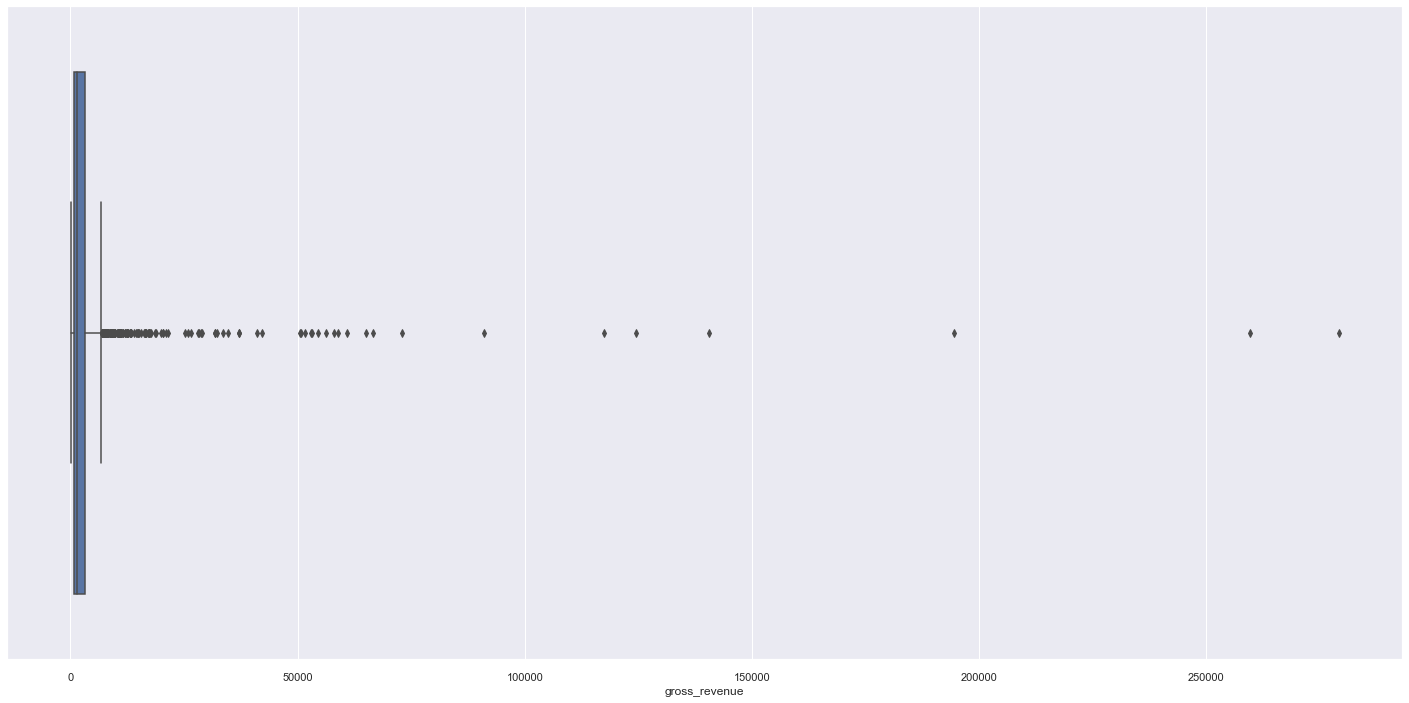

In [137]:
sns.boxplot( x=df10.loc[df10['cluster'] == 0, 'gross_revenue'] )

<AxesSubplot:xlabel='gross_revenue'>

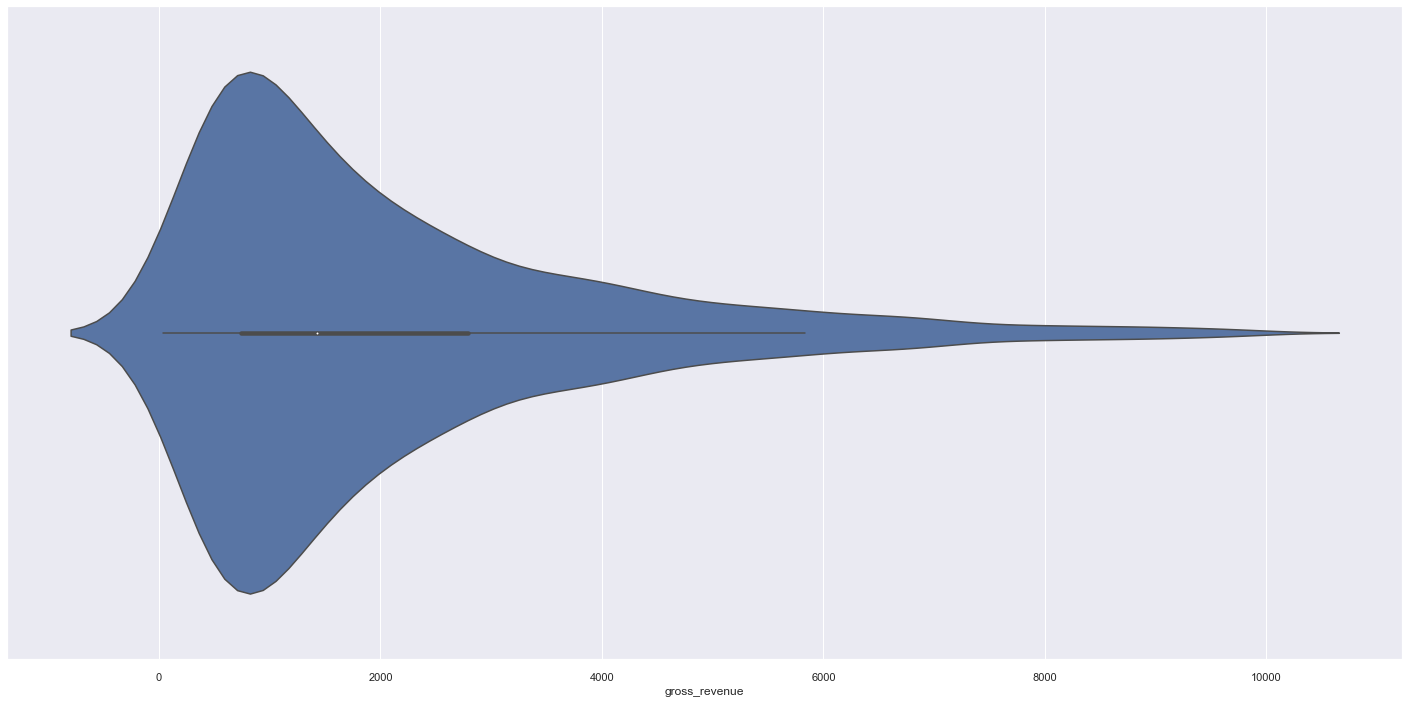

In [138]:
aux = df10.loc[(df10['cluster'] == 0) & (df10['gross_revenue'] < 10000), 'gross_revenue'];
sns.violinplot( x=aux)

# Business Question

1. **Who are the eligible people for the Insiders Program?**
    * Are the customer from cluster 0 .

In [139]:
d = df10.loc[df10['cluster'] == 0, 'customer_id'].head()
d.head()

2    12583
5    15291
6    14688
7    17809
8    15311
Name: customer_id, dtype: int64

**2. How many people will be in the group?**

* 1827 customers
    

In [140]:
df10.loc[df10['cluster'] == 0, 'customer_id'].size

1877

**3. Which are the main characteristics of these customers?**
- They spend a lot.
- has low recency.
- They buy a lot of products.


In [141]:

df_cluster.sort_values( 'gross_revenue', ascending=False )

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_products,frequency,qtde_returns
0,0,1877,32.958736,3742.404017,18.850293,172.156100,0.059919,41.135855
1,1,1276,22.405619,1211.506975,193.335423,67.780564,0.317785,74.065047
2,2,1314,23.072871,618.281826,72.194825,44.295282,1.024272,3.391933
3,3,1228,21.562774,587.834520,235.310261,48.519544,1.020358,1.544788


**4. What is the percentage revenue contribution coming from Insiders?**
* The percentage revenue contribution will be 69%    

In [143]:
df_insiders_gmv = df10.loc[df10[ 'cluster' ] ==0, 'gross_revenue'].sum()
df_all_gmv = df10.loc[:,'gross_revenue'].sum()

print( 'GMV from Insiders: {}%'.format( 100 * df_insiders_gmv / df_all_gmv ) )

GMV from Insiders: 69.51736611658917%


**5. What is the revenue expectation for the next few months?**
    

* To have the answer, it's would take some time to see how the model is performing by the time.

**6. Which are the conditions for the people to be eligible from the program?**


What is a good customer?

* The customer who buys a large quantity of products;
* The customer who has a low recency.
* The customer who has a high frequency.

**7. Which are the conditions for the people to be removed from the program?**

What is a good customer?
* The customer who buys a large quantity of products;
* The customer who has a low recency.
* The customer who has a high frequency.
    

Customers who do not fit these criteria will be removed.

**9. What is the guarantee that the Insiders Program is better than the rest of the base?**
    


* The garantee is that Insiders Program has increased the company revenue in 69%, compared to the total base, totalizing $ 10,104,658.35

In [146]:
# qtde of products
df_gmv_insiders = df10.loc[df10['cluster'] == 0, 'gross_revenue'].sum()
df_gmv_total= df10.loc[:, 'gross_revenue'].sum()

# Total products
print( '% GMV Insiders: {: .2f}%'.format( 100 * df_gmv_insiders / df_gmv_total ) )

% GMV Insiders:  69.52%


In [147]:
print( '% Expected Contribution: {: .2f}'.format( df_gmv_total ) )

% Expected Contribution:  10104658.35


**10. What are the action the marketing team can do to enhance the revenue?**
    

* Apply the clustering model;
* Increase the frequence from  cluste 0. 
* Indentify which products has more returns and why they are returning;
* Make the customer buy more expensive products;
* Create strategy to make the customer returns more often and decrease the recency;